In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

In [3]:
# 출력 옵션 설정
pd.set_option('display.max_columns', None)  # 모든 열 출력

In [4]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [5]:
# 	/Quezon City/Philippines -> Philippines 변경
df_train['customer_country'] = df_train['customer_country'].apply(lambda x: x.rsplit('/', 1)[-1].strip() if isinstance(x, str) else x)
df_train['customer_country'] = df_train['customer_country.1'].apply(lambda x: x.rsplit('/', 1)[-1].strip() if isinstance(x, str) else x)

# 	/Quezon City/Philippines -> Philippines 변경
df_test['customer_country'] = df_test['customer_country'].apply(lambda x: x.rsplit('/', 1)[-1].strip() if isinstance(x, str) else x)
df_test['customer_country'] = df_test['customer_country.1'].apply(lambda x: x.rsplit('/', 1)[-1].strip() if isinstance(x, str) else x)

In [6]:
df_all = pd.concat([df_train, df_test])
df_all.shape, df_train.shape, df_test.shape

C:\Users\hanji\AppData\Local\Temp\ipykernel_7612\2133486542.py:1: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_all = pd.concat([df_train, df_test])


((64570, 30), (59299, 29), (5271, 30))

In [7]:
# 열 삭제
drop_col = ['customer_country.1', 'id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver',
            'product_subcategory', 'product_modelname', 'business_area', 'business_subarea', 'ver_cus', 'ver_pro']

df_all.drop(columns = drop_col, inplace = True)
df_all.isnull().sum()

bant_submit                    0
customer_country             982
business_unit                  0
com_reg_ver_win_rate       48214
customer_idx                   0
customer_type              45418
enterprise                     0
historical_existing_cnt    49539
customer_job               20172
lead_desc_length               0
inquiry_type                2233
product_category           21232
customer_position              0
response_corporate             0
expected_timeline          33271
ver_win_rate_x             43780
ver_win_ratio_per_bu       47360
lead_owner                     0
is_converted                5271
id                         59299
dtype: int64

In [8]:
# 결측값 0으로 넣을 컬럼
fillna_col = ['com_reg_ver_win_rate', 'historical_existing_cnt',
             'ver_win_rate_x', 'ver_win_ratio_per_bu']

for col in fillna_col:
    df_all[col] = df_all[col].fillna(0)

df_all.isnull().sum()

bant_submit                    0
customer_country             982
business_unit                  0
com_reg_ver_win_rate           0
customer_idx                   0
customer_type              45418
enterprise                     0
historical_existing_cnt        0
customer_job               20172
lead_desc_length               0
inquiry_type                2233
product_category           21232
customer_position              0
response_corporate             0
expected_timeline          33271
ver_win_rate_x                 0
ver_win_ratio_per_bu           0
lead_owner                     0
is_converted                5271
id                         59299
dtype: int64

In [9]:
df_all['customer_type'] = df_all['customer_type'].str.lower()
df_all['customer_type'] = df_all['customer_type'].replace(['etc.', 'other', 'others'], 'etc')
df_all['customer_type'] = df_all['customer_type'].replace(['end-customer', 'end customer', 'end-user'], 'end_user')
df_all['customer_type'] = df_all['customer_type'].replace(['specifier/ influencer', 'specifier / influencer'], 'influencer')
df_all['customer_type'] = df_all['customer_type'].replace(['homeowner', 'home owner'], 'home_owner')
df_all['customer_type'] = df_all['customer_type'].replace(['software/solution provider', 'software / solution provider'], 'solution_provider')
df_all['customer_type'] = df_all['customer_type'].replace(['engineer', 'hvac engineer'], 'engineer')
df_all['customer_type'] = df_all['customer_type'].replace(['distributor', 'dealer/distributor'], 'distributor')
df_all['customer_type'].fillna('etc', inplace = True)

In [10]:
# value_counts 가 1개인 것들 etc로 분류
value_counts = df_all['customer_type'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_type'] = df_all['customer_type'].apply(lambda x: 'etc' if x in values_to_replace else x)

In [11]:
df_all['inquiry_type'] = df_all['inquiry_type'].str.lower()
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['etc.', 'other', 'other_', 'others'], 'etc')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['sales inquiry', 'sales', 'probeam precio'], 'sales inquiry')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['quotation or purchase consultation', 'request for quotation or purchase', 'quotation_or_purchase_consultation', 'purchase or quotation', 'quotation_', 'purchase'], 'quotation_or_purchase_consultation')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['usage or technical consultation', 'technical consultation', 'request for technical consulting', 'usage_or_technical_consultation', 'technical_consultation', 'technical'], 'usage or technical consultation')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['vui lòng báo giá giúp mình sản phẩm đo thân nhiệt xin cảm ơn', 'tôi cần tham khảo giá và giải pháp từ lg'], 'quotation_or_purchase_consultation')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung'], 'product information')

In [12]:
# value_counts 가 1개인 것들 etc로 분류
value_counts = df_all['inquiry_type'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['inquiry_type'] = df_all['inquiry_type'].apply(lambda x: 'etc' if x in values_to_replace else x)

In [13]:
df_all['inquiry_type'].fillna('etc', inplace = True)

In [14]:
# custoper_position 전처리
df_all['customer_position'] = df_all['customer_position'].replace(['ceo/founder', 'partner', 'vice president', 'c-level executive', 'director', 'vicepresident', 'c-levelexecutive', 'vp','leadership/executive office/owner', 'president'
                                                                   'principal & director', 'business partner', 'chairman', 'co-founder', 'chief executive officer', 'subsidiary sales (ise)', 'ceo/fundador', 'gerente', 'the big boss',
                                                                  'principal & director', 'president'], 'ceo')
df_all['customer_position'] = df_all['customer_position'].replace(['consultant', 'commercial consultant', 'architecture/consult', 'architect/consultant'], 'consult')
df_all['customer_position'] = df_all['customer_position'].replace(['customer', 'customer_position'], 'customer')
df_all['customer_position'] = df_all['customer_position'].replace(['decision-influencer', 'decision maker', 'decision influencer'], 'decision')
df_all['customer_position'] = df_all['customer_position'].replace(['distributor', 'cargo'], 'distributor')
df_all['customer_position'] = df_all['customer_position'].replace(['physics teacher','assistant professor','maths lecturer','science teacher','guest faculty','physics faculty','teacher/middle school coordinator','prof.',
                                                                   'academic specialist','principal at oxford integrated pu science college','math and physics teacher','professor of mathematics','physics and mathematics teacher',
                                                                   'assistant professor of english','educator','professor','quantitative aptitude faculty','english trainer for ielts,toefl,pte,gre,sat exams.','associate professor',
                                                                   'pgt physics','education professional','chemistry teacher','director cum faculty at gaining apex coaching centre','teacher','senior lecturer',
                                                                   'neet/ olympiad expert faculty','associate professor in electronics engg','education','pgt chemistry', 
                                                                   'academic coordinator/ post graduate teacher (accountancy, business studies)/ tgt (ict)','assistant professor of enlish'], 'education')
df_all['customer_position'] = df_all['customer_position'].replace(['entry level','intern','trainee','entrylevel','employee'], 'employee')

df_all['customer_position'] = df_all['customer_position'].replace(['exhibition','exhibitiontv'], 'exhibition')
df_all['customer_position'] = df_all['customer_position'].replace(['hospital', 'medical device manufacturer', 'medical imaging specialist', 'tierarzt', 'surgery professional', 'pathologist'], 'medical')
df_all['customer_position'] = df_all['customer_position'].replace(['not applicable','none','other','others'], 'etc')
df_all['customer_position'] = df_all['customer_position'].replace(['manager','associate/analyst','consulting','lider de desarrollo','decision-maker','business unit director','business development','operations',
                                                                   'product management','market intelligence/research'], 'pm')
df_all['customer_position'] = df_all['customer_position'].replace(['asst prof.','professional trainer','radiology professional'], 'professional')
df_all['customer_position'] = df_all['customer_position'].replace(['this is a consume display requirement for home purpose.','unpaid','homeowner','no influence'], 'unemployed')

In [15]:
# value_counts가 1인거 etc로 묶기
value_counts = df_all['customer_position'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_position'] = df_all['customer_position'].apply(lambda x: 'etc' if x in values_to_replace else x)
df_all['customer_position'].fillna('etc', inplace = True)

In [16]:
# 전처리 필요한 4개 컬럼 간단하게
value_counts = df_all['customer_job'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'other' if x in values_to_replace else x)
df_all['customer_job'].fillna('other', inplace = True)

value_counts = df_all['product_category'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'etc' if x in values_to_replace else x)
df_all['product_category'].fillna('etc', inplace = True)

value_counts = df_all['customer_country'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_country'] = df_all['customer_country'].apply(lambda x: 'etc' if x in values_to_replace else x)
df_all['customer_country'].fillna('etc', inplace = True)

In [17]:
len(df_all['expected_timeline'].unique())

450

In [18]:
expected_timeline = df_all['expected_timeline']

In [19]:
expected_timeline = expected_timeline.str.replace('-', '')
expected_timeline = expected_timeline.str.replace('_', '')
expected_timeline = expected_timeline.str.replace('~', '')
expected_timeline = expected_timeline.str.replace(' ', '')
expected_timeline = expected_timeline.str.replace('.', '')
expected_timeline = expected_timeline.str.replace('etc', 'others')

C:\Users\hanji\AppData\Local\Temp\ipykernel_7612\1771432554.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  expected_timeline = expected_timeline.str.replace('.', '')


In [20]:
sort_df = expected_timeline.fillna('others')
sort_df

0       lessthan3months
1       lessthan3months
2       lessthan3months
3       lessthan3months
4       lessthan3months
             ...       
5266             others
5267             others
5268    lessthan3months
5269             others
5270             others
Name: expected_timeline, Length: 64570, dtype: object

In [21]:
values = ['aggressivepricerequired',
       'alreadycloseinjulypurchsewithrd', 'alreadyconnectwithpartner',
       'alreadyindiscussionwithpartnerfrombangalore(kohinoor)andwithmr.indraneelfromcorporateoffice',
       'alreadyintouchwithcustomer',
       'alreadyintouchwithcustomerfromlast10days.droppingitbecausewearealreadyintouch',
       'alreadyintouchwithhimsincelong.hehasnotfinalizedyet.leadforwardedtord',
       'alreadyintouchwithpartner.', 'alreadyintouchwiththereteam',
       'alreadyourcustomer,havesharedpricesfornewrequirement',
       'alreadypurchasewithrd', 'alreadysharedquotationthroughsi.',
       'alreadytouchwithcustomerforkioskrequirement',
       'alreadytouchwithcustomers',
       'alreadyworkingonidbwillcreateopppostclarfyingonsignage',
       'alreadyworkingwithenduseronthisrequirement.',
       'askedtocallbacklater,ihadsharedthisleadwithrdtotakeitfurther.',
       'askedtocallbacktomorrow,ihadsharedthisenquirywithrd.',
       'askedtocallbacktomorrowmorning,notresponding',
       'askedtocalllater.','(selectidtimeline)', '09022022requestedforboqofrequirement',
       '14:0015:00',
       '14thaugaggressivepricerequiredashehasgotpricefromoutsidedelhi',
       '14thfeb2022shareddetails.awaitingupdatefromcustomer.',
       '25nov2021nomobilenumber,sentamailtocustomer',
       '29thsep2021:nosuchrequirementasofnow', '14thfeb2022shareddetailsawaitingupdatefromcustomer','alreadyintouchwithcustomerfromlast10daysdroppingitbecausewearealreadyintouch',
       'alreadyintouchwithhimsincelonghehasnotfinalizedyetleadforwardedtord',
       'alreadyintouchwithpartner', 'alreadysharedquotationthroughsi',
       'alreadyworkingwithenduseronthisrequirement',
       'askedtocallbacklater,ihadsharedthisleadwithrdtotakeitfurther','alreadyindiscussionwithpartnerfrombangalore(kohinoor)andwithmrindraneelfromcorporateoffice',
       'askedtocalllater', 'askedtocallon4thmay',
       'askedtocontacthimafter8thjan', 'askedtosenddetails',
       'askedtosharedetailsonmailhewillupdateifthereisanyrequirement',
       'assignedtopartnerintialmeetingdonewillconverttoopppostcompleteinfo',
       'atpresentnotrequired,', 'beingfollowedup',
       'bodeli,requirementpendingnewquotesendcloseinthismonthend',
       'budgetissue', 'budgetlowhenceclienthavenotwentahead',
       'budgetproblem', 'busy,calllater', 'busyneedtocallback',
       'callafter3june', 'callanddiscusednorequirement',
       'callanddiscusedtocustomecustomerwantsdemo',
       'callbackagainon30/04', 'callbacklater',
       'callbacklater,infirstweekmarch', 'calledtoknowthepriceofidb',
       'callnotconnecting', 'callnotpicking',
       'clienthaveseenthedemoheneededforbiggerroomandthecameraqualityandspeakertrackingwerethemainrequiredfeatureasofnow,hisbudgetisaround2lacsandneedbiggersizesolutionthereisnoresponsefromclientpostdemohenceclosing',
       'clientiscrosscheckingonpricesitsarccaseofsubwayandthefranchiseeistryingtogetpricingfromelsewhere',
       'clientisexploringhewilldiscussoncedetailssentdetailsmailedtohimasperrecentdiscussion,heisnotexploringasofnow',
       'clientislookingfor86"displaywithvcsolution,theywillgofordemonextweekanddecideonprocuringourtr3dj,detailssharedwithclientonmail',
       'clientisnothavinganyrequirement,hewasonlybrowsingthroughtheproduthenceclosiginsystemalthoughthedetailsofidbaremailedtoclient',
       'clientisnotlookingnowandhewasinterestedwithonlyinbuiltopsoptionhenceclosinginsystemasheisnotrespondingtocalls',
       'clientisnotrespondingcalls,followingupandkeeptheupdatetracked',
       'clientnotanweringcallsandaskedthereisnorequirementhewastryingtocheckpricesforone65touchrequirementofexistingclient',
       'clientnotinterestedinproductreceingcallandnotansweringproperly',
       'clientshallgetbackforexploringdemoofidb,postthattheywilldecideonprocuringthesame',
       'clientwasbusy,askedtocallbacklater,interestedinexploringouridb',
       'clientwasdrivingandaskedtocallbacklater,willfolloupandkeepposted',
       'clientwasexploringonproductsbuthedonthaveanyplanstopurchasecurrentlyhehaveholdedonhisrequirementandwillconnectifitreiniitaties',
       'clientwasinquiringforpricesalreadyquotedbyfewpartnerstheyevenpurchasedasperrecentupdatebutclienthasnotconfiermedpartnername',
       'clientwaskeentoexploreouridbsku,infollowup', 'cmsreqired',
       'communicationnumbernotavailable',
       'concernedpersonnotavailable,willcalllater',
       'conference/meetingroom/collaborationspaces',
       'connectedwithpartnerforstudiosetupwithcamera',
       'connectingforissue', 'connectwithpartner',
       'contactdetailsprovidedarewrong,sentmailforcorrectcontactdetails',
       'convertedthisleadintoopportunity', "couldn'tconect",
       "couldn'tconnect", 'couldntconnect',
       'customehasnotreceivecallason31stmayspokewithcustomer,hewillcomefordemoinnextweek14062022',
       'customepurchaseconsumerproduct', 'customerasktocallbacktomorrow',
       'customerbudgetis125+taxfor75inchidbihavegivenournoregretofferandalsoexplainedwhylgisbetterandpremiumhesaidhewillcomebackinadayortwo',
       'customergettingpricefromjaipurwhichlowthanouroperatingprice',
       'customerhasbeennotansweringcall', 'customerhasnotansweringcall',
       'customerhasnotansweringcall/customerwant86"interactivedisplay,hewillpurchasewithinnext6month,weareforwardingtolocalrdtotakethisfurther',
       'customerhasnotansweringcall/quotationhasbeensendtocustomer',
       'customerisbusyaskustocallagain,following',
       'customerislookingforresidential43inchdisplayforhomeuse',
       'customerneedshortthrowprojector',
       'customernotansweringcall,willcallhimagainandupdate',
       'customerphoneisgetsswitchedoff',
       'customerpurchasebenqforpricedifferance',
       'customervisitatuvbusinessandseethedemowithin2to3days',
       'customerwantdemoofidbhewillcomefordemoinnextweekafterfollowingupwithcustomermultipletimesthereisnoupdateleadhasbeenforwardedtord',
       'customerwantproductt15000',
       'customerwillbecomingfordemoon28thmaycustomerdidnotcamefordemoihaveshareddetailswithrdtotakeitfurtherhencedroppingthislead',
       'customerwillcomefordemoinnextweek,thanhewilldecidefurther',
       'december2022', 'delhienquirey', 'demoalignedforclient',
       'democompleted,customeraskedtocomefeb10thforclosure', 'demodone',
       'demodoneanddetailsshared',
       'demoplanned,willupdatefurtherstatusonceitscompleted',
       'demoscheduledfor24thoct', 'demoscheduledforfirstweekfeb',
       'demotobealigned', 'demotobeplanned',
       'detailsharedwithhimonemailheislookingforoneunitof65inchforhisconferenceroom',
       'detailssend', 'detailssendquoterequire', 'detailssendrequiredemo',
       'detailsshared', 'detailsshared,beingfollowedup',
       'detailsshared,toplandemoindecember',
       'detailssharedfollowupunderprogress',
       'detailssharedfor75tr,followupinfirstweekofoct',
       'detailssharedfuunderprogress',
       "detailssharedonwhatsapp,he'llrevertback",
       'detailssharedwithconcernpersonwillaskbdotofollowup',
       'detailssharedwithcustomer,alsoihadsharedleadwithrdtotakeitfurther',
       'detailssharedwithcustomer,hewillupdateonfurtheractionafterevaluatingotherbrandsaswell',
       'detailssharedwithcustomerason4thmaytriedmultipletimesbutnotreachable',
       'detailssharedwithcustomeronmai',
       'detailssharedwithcustomeronmail',
       'detailssharedwithpartnerhehasquotedinourexistingcustomeronly',
       'detailssharedwithrdforfurtheraction,',
       'dicsussedwithclient,detailssharedonmail,clienthavenobudgetstobuynowhenceclosinginthesystem',
       "didn'tpickupthecall", "didn'trespond", "didn'trespondtocalls",
       "dind'trespond", 'discusedwithankitindehli',
       'discussedandshareddetailswithclientfordigitalsignagetheyarenotplanningtopurchsethesamecurrentlyhenceclosinginthesystem',
       'discussedwithclient,detailsmailedforidbandonequick,theyhavenoplantobuyfornowhenceclosinginthesystem',
       'discussedwithclient,detailsmailedtheyarenotplanningtopurchasefornowhenceclosinginthesystem',
       'discussedwithclient,detailssharedonmailclienthavenopurchaseplansfornowhenceclosingthesameinsystem',
       'discussedwithclient,heshallsendthedetailsoftheirofficerequirement',
       'discussedwithclient,quotesent',
       'discussedwithclient,theywerejustevaluatingtheproduct,theyhavenoplanstobuythesame,henceclosinginthesystem',
       'discussedwithclientdemoalignedoncedone,willupdate',
       'discussedwithclientdetailsmailedclientdonthavebudgetforpurchasenowhenceclosinginthesystem',
       'discussedwithclientdetailsmailedforonequick,theyarenotplanningtobuythesamefornowhenceclosinginthesystem',
       'discussedwithclientdetailsmailedtheyhavebudgeissuefornowsotheywontbuyhenceclosinginyhesystem',
       'discussedwithclientdetailsmailedtoclientnobudgetsfornowwontbuyhenceclosinginthesystem',
       'discussedwithclienttheyarelookingforaiosolutionwithvctheywillcallafter20thforthedemoandthenpurchasethroughgem',
       'discussedwithclienttheyarenotevaluatuatingidbasofnow,theyhavenoplanstobuyhenceclosinginthesystem',
       'discussedwithclienttheyhavenobudgetsforpurchasefornow,theywontbuyhenceclosinginthesystem',
       'discussedwithclienttheyneed24inchdisplayfordigitalsignagementionedforouravailablesizes,heshallrevert',
       'discussedwithclienttheyneedforcsractivitypricesexpectationisverymuchlow',
       'discussedwithclientweneedtoaligndemotheexpectationisconnectingappledevicesbutnotmandatoryoncedemoisdone,weshallupdate',
       'discussedwithclientwillplanfordemo',
       'discussedwithpartnerheworkswithcloudwalkerandwantedtoconnectwithusforsomeproductdetailsasofnow,donthaveanyinquirytoworkandhenceclosinginsystem',
       'discussedwiththeclient,tr3bg&onequickworksdemoscheduledon27thjuly2022postdemotheywilldecideonprocuringtheunit',
       'discussedwiththeclientaskedtocallbackonmondaywillkeepafollowup',
       'discussedwiththeclienthedonthavebudgetsdetailsmailedhewontbuynowhenceclosinginthesystem',
       'discussedwiththeclientpricessharedforonequickandidbonmailcustomertoconfirmaboutdemooftheskuandfinaliseonprocurement',
       'discussedwiththeclienttheyareintererstedinourtr3djseriesdemoplannedfor29thjuneposttheywillplanonprocurementwillkeepupdate',
       'discussedwiththeclienttheypurchased65um3dffromthechannelunabletotrackthesupplierhenceclosinginthesystemmailsenttoclientforourdisplayrange',
       'discussiontobedonewithcustomer',
       'donthaveanyimmediaterequirementhemaypurchaseafterjune',
       'donthavebudgethewantdotled', 'don’thavebudget',
       'drop,alreadydonewithpartner',
       'drop,budgetproblemnowphonenotrespondig',
       'drop,lookongforconsumerproduct', 'drop,notintrested',
       'drop,nownotintrested',
       'drop,requirementofinteractivetouchscreentosupplyingovt,conncgtwithpartner',
       'drop,stillnoplanforpurchase', 'drop,wrongnumber',
       'dropnoplanforpurchase',
       'dropnotwillingtobuynowwilldoinfuturedetailssharedonwhatsap',
       'dropped,requiresdevicelikeonequicksharetobeusedwithsamsungtv',
       'droppedcontactnonotvalid', 'droppedhavepurchasedcloudwalker',
       'duetobudgetissue,customerhasboughtmaxhubpanel',
       'duetofinancialreasons,clienthavedroppedpurchaseplanalthoughthedetailsofidbaremailedtoclient',
       'duplicatelead',
       'duplicateleadil220100042906discussedwithclienttheirvchallisunderdevelopmentonequickdetailsmailedtoclienttheywillcallusfordemoandpurchasefinalizationoncetheirvcplaceisready',
         'emailsendfordetailsclientisexploringonsolutionsbutonlyfortheirundertanding',
       'existingcaseworkedbyourdisti,crewbusiness,henceclosingasclientisonlycheckingforcommercials',
       'existingpartner,discussedandaddressedtheconcernthepartnerhadtakenpricingandwantedtorecheckasthemodelquotedischanged',
       'exitingcustomer',
       'financeandaccountingconsultantinquiredfoe43inchaiobutdonthaveplanstobuydetailsdiscussed',
       'followingup', 'forwardedtoaurangabadrdforfurtherprocess',
       'forwardedtobdo,beingfollowedup', 'forwardedtobdotofollowup',
       'fuunderprogress','heaskedtosharebudgetoryquote,hewillcheckandconfirmifhewillrequiretheproduct',
       'heclientisnothavinganyrequirementhenceclosiginsystemalthoughthedetailsofidbaremailedtoclient',
       'hehasaskedtoconnectnextweekhewanttoseethephysicaldemo',
       'heisaneventorganizationandlookingforrentaldisplayshencedroppinginsystem',
       'heiscomparingwithsenseswhichislocalbrand',
       'heisindiscussioninternallyandwillupdate',
       'heislookingforaninteractivedisplaydiscussedwithclient,willupdateasthecaseprogress',
       'heislookingforconsumerproductforhome','heislookingforinteractivedisplayquotesharedwithhim',
       'heislookingforvideowall&idbforhisofficeourbdojayantisintouchwithhimandsharingtherequireddetailstocustomer',
       'heisrequestingdemoinaligarhup,plzsharetoupperson',
       'hejustneedbudgetorypricingwehavesharedthedetailswithhimandrequestedhimtocomefordemo',
       'heneedsforhomepurposeandisaconsumerclientspokeandguidedonthedetailsandchannelnotab2brequirement',
       'hewant32inchtvforsignagedetailssharedwithhim',
       'hewant65inchat50k', 'hewant98inchinbelow2lacs',
       'hewantdemoinaurangabad,detailssharedwithrd',
       'hewantdemoinlaturandalsodonthavemuchbudgetpartnerfollowedupmultipletimesbutnoresponse',
       'hewantdemoinsangli,ihaveloopedwithlocalpartner',
       'hewantphysicaldemooftr3bfinnashikbuttherebudgetisalsoverylowsofirsthewilldiscusswithmanagementonbudgetthenconfirmbackfordemo',
       'hewillcallbackifneeded', 'hisbudgetisunder50konly',
       'hisbudgetisverylow',
       'hisbudgetisverylowbutwearetryingtoconvincehimfor65inch',
       'idbdetaissend',
       'il220100042906repeatinquiryhenceclosingthisinsystem',
       'invalidlead',
       'isaninteriordesignerworkingonturnkeyprojectsmrbhuvneshisincontactandsharedspecsandprices',
       'itsbiharcustomer',
       'kinnarieletronisvatwahasbidforthesameandtheyaregoingtopurchasefromthem',
       'knownpartnerandalreadyworkingonacaseonlycrosscheckingpriceshencedropping',
       'knownpartnerandwehaveinstalled3videowallspanindiaforcctvwesupplied49vl5batrs62000andthenagain49vl5fatrs71000nowtheavailablemodelis49vl5gat80000+whichpartnerisrecheckingandhencemadeinquiryclosingtheinquirysi',
       'leadbelongstomaharashtra','lookingforactiveledinarangeof5lakhsnotaprospetivebuyer',
       'lookingforairconditioners',
       'lookingforcommercialtv55"detailsmailedtoclient,theyhavenoplansfornowtobuyhenceclosinginthesystem',
       'lookingforhomeuse',
       'lookingfornotmadeinchinaactiveoutdoorledforgovernmentproject',
       'lookingforoutdoordisplaycusotmerhasnoclarityonthesolutionemailsharedforunderstandingandwaitingforreply',
       'lowbudget', 'maileddetails&priceof55inches',
       'mayurelectronicconnectwithclient', 'meetingdatetobefinalised',
       'meetingplannedforfurtherdiscussion','mobileisswitchedofftried3times','mrrajnikantisallignwiththeclient',
       'needforhomesegmenttheypurchasedvu85inchtvfortheirhome',
       'needtoarrangequoteanddemo', 'needtododomestictradebiz',
       'nextweekhewillcomefordemoatlgoffice',
       'nocontactnumber,ihavedroppedaemailrequestingforthesame',
       'nodropthislead,nobudget!',
       'nofurtherrevert&clarityaftersharingdetails', 'noreqirements',
       'norequirement', 'norequirementofthistime', 'noresponse',
       'noresponseonmailsfromtheclientcouldntfindanycontactdetailsonnetaswellhencedroppinginthesystemalthoughidbandonequickdetailssharedonemail',
       'notansweringcall', 'notansweringcall,detailssharedwithrd',
       'notansweringcall,leadsharedwithrd',
       'notansweringcall,salesremarks:triedtoreachhimmultipletimesbutheisnotrespondingrequesttoshailjatoreconnectwithcustomerwearedroppingthisleadfornow',
       'notansweringcall,sharedleadwithrd',
       'notansweringcall,willtrytoreachhimagain',
       'notansweringcall|ason11thjunecustomerphoneisnotreachableiamdroppingthisleadandforwardingtopartner',
       'notansweringtriedseveraltimesdetailssharedwithrd',
       'notinterested', 'notinterestedatthemoment',
       'notinterestedincommercialtvs', 'notlifted', 'notlifted,calllater',
       'notpickingcalls,calledmanytimes', 'notreachable',
       'notreachable,detailssharedwithrd',
       'notreachable,ihadsharedleadwithpartner',
       'notreachable,leadsharedwithpartner', 'notrequire', 'notrequired',
       'notrequirednow', 'notresponding',
       'notresponding,detailssharedwithlocalrd', 'notrespondingtocalls',
       'notrespondingtriedmanytimes', 'november2022', 'november22',
       'october2022','ordertaken',
       'ourpartner,visnetworksisworkingonthisinquiryandclientiscrosscheckingthepriceshenceclosinginthesystem',
       'partnerisalreadyintouchwithourrd,ornothepartnerneedstocrosscheckontheinformationasthesizeischangedfrom49to50nowclosingtheopprtunityasitsexistingwithrd',
       'partnerisintostaticsignagesheneedtoconnectfordigitalsignagebuthehimselfismanufactureralthoughamailinitaitedforanyrequirementswithledteamtotakeitaheadasofnow,thereisnoscopehenceclosinginsystem',
       "partnerisworkingonexistingrequirementheisconnectedwithourdisti'sforbilling",
       'partnerwasexploringoneolmodelforsomerequiremeentnodesignatedsalesorclosureexpectedhenceclosinginthesystem',
       'phonenumbernotavailable', 'phoneswtichedoff', 'priceshared',
       'pricesharedwithcustomerheislookingforsomeidbsneedtotakefollowup',
       'pricesharewithcustomerourrdisfollowingupwithhimbutcustomerisnotresponding',
       'projectcancle',
       'proposalsubmitted,duetocovidmdisnotcomintoofficeforthemeeting',
       'providedmodelandpriceasperrequirement',
       'purchasedfrombinary@123l', 'purchasedsomelocalpanel,budgetissue',
       'purchasedviewsonicpanel','purchasevubrand',
       'quotationsent–75tr3dj,workinprogress,hewillbuyafter2monthshehasnotevenseenthequoteyet',
       'quotationshared',
       'quotationsharedforultrastrothershand49vl5ghewillcheckwithmanagementandupdateus',
       'quotationsharedincommunication', 'quotationsharedwithcustomer',
       'quotationsharedwithcustomer,hewillconfirmbackafterdiscussingwithmanagement09062022asontoday14062022notansweringcallhenceiamdroppingthisleaddetailsshredwithrdtakeitforfurther',
       'quotationsharedwithhimforidbhedonthaveenoughfundasofnowheisjustevaluatingoptions',
       'quotehasbeensenttocustomer', 'quotesend',
       'quotesendmeetingpending', 'quotesendnextmonthrequire',
       'quotesendrequiredemo', 'quotesendrequiredemoinnextweek',
       'quotesent,theclientisrequireddemoinjune', 'quotesenttocustomer',
       'quotesharedbuttherebudgetisverylow',
       'quotesharedfor86inchheisevaluationlocalbrandoftrueview',
       'quotesharedwithcustomer,hewillconfirmafter2monthsleadsharedwithpartner',
       'quotesharedwithcustomer,leadsharedwithpartnertotakeitfurther',
       'quotesharedwithcustomerhewillrevertwithanupdate',
       'quotesharedwithhim',
       'quotesharedwithhimandhewillupdateusafterdemo',
       'rajnikantisworkinginthiscasehoinahmedabadanditsunderprocess',
       'receivedpo', 'recentlynorequirement,dropped',
       'remarks:customerlookingfor65inchesand75incheseach1qty',
       'repeatedinquiryfromclienthewasjustinquiringbuthavenotconfimredonpurchasewehavetriedmulitpletimesbutclientisnotinterestedinbuying',
       'repeatenquiry',
       'repeatinquiry,wealreadyknewontheclientrequirementweareintouchwiththemandifanyrequirementcomes,wewilludpateasofnow,thetransparentledtheyneedisnotavailablewithusandtheavailableproductcostexpectationisverylowwit',
       'require65inchidbunder80k', 'requiredemo', 'requiredemoafter20may',
       'requiredemopricesend',
       'requirementisforpuneloopedpuneteamalthoughthepartnerischeckingpricesforanexistingcaseclosingtheleadinsystemaspuneteamisalreadyworking',
       'requirementof65tr3dj',
       'requirementof65tr3djandcustomerwantdemo,detailssharedwithrd',
       'requirementof65tr3dj–demoreqired,leadsharedwithrd',
       'requirementof65tr3dj–demorequired',
       'requirementof75tr3dj–demo,detailssharedwithrd',
       'requirementof75tr3dj–demo,leadsharedwithmumbaiteam',
       'requirementof75tr3dj–demorequired',
       'requirementofidb,budgetisverylowshareddetailsonwhatsapp1unitrequiredrdisfollowingup',
       'requirementofvideowallclientischekingonpricesalready2partnersworkingitsongoingcasehenceclisinginsystem',
       'requireonlycmssoftware', 'requirequote',
       'requiresdetailfortendernopurchaserequirementrightnow',
       'resellerwanttohavegemauthorization',
       'reuiredforofficeaskedtosharequotation', 'rnr',
       'sameasleadnoil220300046498hencedroppingduplicatelead',
       'schedulingameeting', 'september', 'september2022',
       'sizenotavailable', 'smallsizetabrequired',
       'spokentoclient,hewillcheckiftheyneeddemoandconfirm',
       'spokentoclient,hewillconnectoncehediscussonrequirement',
       'spokentopartner,havenoanyrequierementsfornow,havemailedthedetailstohim,hewontpurchaseanyskusfornowhenceclosinginthesystem',
       'spokewithcustomehewant43"tv',
       'spokewithcustomer,detailsneedstoshareonmailalsotheywantdemo',
       'spokewithcustomer,heislookingfordotledproductin42inch,ihavesuggestedhimour43inchsignagebuthewantfullyoutdoorledihavesharedthedetailsofour43inchdisplay',
       'spokewithcustomer,willbesharingdetailsonemail',
       'spokewithherandsharedthedetailsforsignagedisplays','theclientbudgetiswithin1lacstheyneed55inchaiosolutionasperdiscussion,theyarecomparingwithjabraandweproposedtocheckiftheyneedonlydisplaysbutduetobudgothersontraint,theyaredroppingtheidea',
       'theclientislookingforsmallsizedisplaysof20inchto25inchtomountonrefthebudgetis4kto6knotexactlyourrequirement',
       'theclientisnothavinganyrequirement,hewasonlybrowsingthroughtheproduthenceclosiginsystemalthoughthedetailsofidbaremailedtoclient',
       'theclientisnothavinganyrequirement,shewasonlybrowsingthroughtheproduthenceclosiginsystemalthoughthedetailsofidbaremailedtoclient',
       'theclientisnothavinganyrequirementhenceclosiginsystemalthoughthedetailsofidbaremailedtoclient',
       'theclientisnothavinganyrequirementhewasjustbrowsingforproductshenceclosiginsystemalthoughthedetailsofidbandvideowallsaremailedtoclient',
       'thepartnerischeckingpriceforanongoingcaseofbarcwehavediscussedonnewcasewiththepartneritsusefultotakeourdiscussionfurtherfornewinquriesclosingtheopportunityinsystemasofnowasitsmadeonlyforcrosscheckingprices',
       'thererquirementisforpuneemailedclientloopingpuneteamtomeetandvisittheclient',
       'theyareconsultantandiamalreadyintouchwithcustomer',
       'theyarehavingrequirementof40displayscustomerneedaggressivepricingthansamsung',
       'treidmanytimesbutphonenotreachable',
       'triedcallingtheclient,noresponsefromclient,ihavemailedidbdetails,willkeepfollowup&update',
       "triedcontacthimbutcouldn'tabletoconnectleadforwardedtord",
       'triedcoupleoftimesbutheisnotrespondingwewilltryagain',
       'triedreachingouttoclientnoresponsetocalllssoihavesharedthedatasheet,shalllfolllllowupandupdate',
       'triedtoreachcustomerbutnoresponseleadforwardedtopartnerforfurtherfollowup',
       'triedtoreachhimbutnoresponseiwillcallhimagain18thnovicalledhimagainandhewillsendtherequirementonmail',
       "triedtoreachhimmultipetimesfromlast7daysbutcouldn'tgetthrough",
       "triedtoreachhimmultipletimes,butcouldn'tgetthru",
       'triedtoreachseveraltimesbutnoresponse', 'underdiscussion','uttarpradeshstatelead',
       'veryabruptcustomersaidtheinquirywasmademonthsagoandwasrudeenoughclosinginthesystemastheclientbehaviourhasnoscopetodiscussonrequirementneedmarketingteamtocheckifthecasewasreceivedindecorjanasperclient',
       'wanttodotradeproductbusiness', 'wanttotakeretailmonitor',
       'wearealreadyintouchwithcustomerthrupartner',
       'wearealreadyintouchwiththiscutsomerfromlast2years,hehasneverpurchasedanyproducttilldateicalledhimuptwicebutnoreponse',
       'wearenotgoingtomatchtechnicalspecification',
       'wehavepitched110inchfuunderprgress',
       'wewerealreadyworkinghere,wearefacingchallengeaswedonthave49vl5ginstockorderlostinmarchduetounavailabiltyof49vl5g',
       'willcomebackonceitisrequired', 'willcomeforthedemo',
       'withdrawnthedecissiontopurchase', 'últimarevisión:26/07/21','underdiscussion,requirementnotdinalisedyet',
       'update14thseptmoredetailstobesharedbyclient',
       'updateaspercustomernoenquirywasmade',
       'updatedetailsalreadysharedwithcustomerevaluationisongoing','uptodecember']

sort_df = sort_df.apply(lambda x: 'others' if x in values else x)
sort_df = sort_df.replace('callbacktomorrow28/09', 'lessthan3months')
sort_df = sort_df.replace('then', 'than')
len(sort_df.unique())

41

In [22]:
values = ['lessthan3months,meetingwiththecustomerforthemoredetailsandtentativeboqwillne32and43',
       'lessthan3monthscustomernotansweredtocallback',
       'lessthan3monthsoutdoorledrequiment', '4/8months', '45days', 'askedtocallbacktomorrow',
          'askedtocallnextweek','askedtocallbacktomorrow,ihadsharedthisenquirywithrd',
         'duplicateleadil220100042906lessthan3months', 'eolmodelnewmodelquoterequirmentafter30days',
         'getbackin1wk','heislookingfordisplayforhisrestauranthehasaskedtocontacthimafter1monthasrestaurantworkisunderprogress',
        'hewantdemonextmonthatpune15may', 'hewantdemonextweek','needtodiscusswithclientinnexttwomonthstheyneedtochecktheproductandaccridnglyproceedforpersonaluse'
          ,'meetingplannednextweek','needtocallonfriday27th', 'onemonth', 'spokewithshubhamwhoisstudenthesaidhewillspeakwithhissirandrevertbackafter2weeks', '3months',
         'update14thseptcustomerwilldiscussindetailtomorrow','update13thspetfollowuptobedoneon15thsept', 'update27thaugcustomerhastocomeforproductdemo',
       'update4thaugcustomeraskedtocallonmonday',
       'update4thaugcustomervisitingexperiencecentreon8thsept',
       'update4thaugdetaileddiscussiontobedoneon6thaug',
       'update7thaugdemogivencustomerwillconfirmnextweek',
       'update8thseptdetailssharedwillconfirmdemoscheduleofnextweek',
       'update9thoctdetailssharedwillconfirmforonlinedemonextweek', 'updatecalltobemadeontuesday',]

sort_df = sort_df.apply(lambda x: 'lessthan3months' if x in values else x)

In [23]:
sort_df = sort_df.replace('lessthen6months', 'lessthan6months')
sort_df = sort_df.replace('lessthan5months', 'lessthan6months')
sort_df = sort_df.replace('morethen3months', 'lessthan6months')
sort_df = sort_df.replace('needshoteltvafter4months,willcallus', 'lessthan6months')

sort_df = sort_df.replace('purchaseplanningafter3months', 'lessthan6months')

In [24]:
len(sort_df.unique())

7

In [25]:
sort_df.unique()

array(['lessthan3months', 'others', '3months6months', '9months1year',
       'morethanayear', '6months9months', 'lessthan6months'], dtype=object)

In [26]:
df_all['expected_timeline'] = sort_df

In [27]:
df_all.expected_timeline.unique()

array(['lessthan3months', 'others', '3months6months', '9months1year',
       'morethanayear', '6months9months', 'lessthan6months'], dtype=object)

In [28]:
value_counts = df_all['expected_timeline'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['expected_timeline'] = df_all['expected_timeline'].apply(lambda x: 'etc' if x in values_to_replace else x)
df_all['expected_timeline'].fillna('etc', inplace = True)

In [29]:
df_all['expected_timeline'].unique()

array(['lessthan3months', 'others', '3months6months', '9months1year',
       'morethanayear', '6months9months', 'lessthan6months'], dtype=object)

In [30]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx + 1
    series = series.map(my_dict)

    return series

In [31]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

In [32]:
df_train = df_all.iloc[:len(df_train)]
df_test = df_all.iloc[len(df_train):]

In [33]:
def get_clf_eval(y_test, y_pred=None):
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['T[0]', 'F[1]'], columns = ['pred_T[0]', 'pred_F[1]'])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [34]:
df_train.shape, df_test.shape

((59299, 20), (5271, 20))

### 언더샘플링

In [35]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

X_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_resample(df_train.drop(["is_converted", 'id'], axis=1), df_train["is_converted"].astype(int))

In [36]:
x_train, x_val, y_train, y_val = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
)

In [37]:
rf_clf = RandomForestClassifier(random_state=42, oob_score = True)
param_grid = {'n_estimators' : np.arange(20, 101, 10),  'max_samples' : [0.8], 
              'max_features' : [0.8], 'criterion' : ["gini", "entropy", "log_loss"],
              'class_weight' : [{0:1, 1:1}]}

grid_rf_clf = GridSearchCV(rf_clf, param_grid, verbose = True, scoring='f1')
grid_rf_clf.fit(x_train, y_train)

print('최적의 파라미터 :', grid_rf_clf.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
최적의 파라미터 : {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 80}


In [38]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=80, criterion = 'entropy', 
                                max_features = 0.8, max_samples = 0.8, class_weight = {0: 1, 1:1}, oob_score = True)
rf_clf.fit(x_train, y_train)

y_pred = rf_clf.predict(x_val)
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = rf_clf.predict(x_test)
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        895         78
F[1]         64        903

정확도: 0.9268
정밀도: 0.9205
재현율: 0.9338
F1: 0.9271


(2148, 5271)

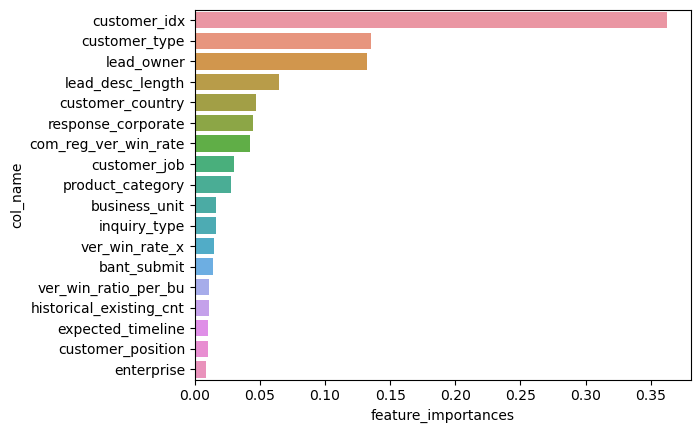

In [39]:
# 변수 중요도
importances = pd.DataFrame(np.mean([tree.feature_importances_ for tree in rf_clf.estimators_], axis = 0))
feature_importances = pd.concat([pd.DataFrame(x_train.columns),importances], axis = 1)
feature_importances.columns = ['col_name', 'feature_importances']
feature_importances = feature_importances.sort_values(by = 'feature_importances', ascending= False).reset_index(drop = True)

# 변수중요도 시각화
sns.barplot(data = feature_importances, y = 'col_name', x = 'feature_importances')
plt.show()

In [40]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

C:\Users\hanji\anaconda3\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [41]:
xgb = XGBClassifier(random_state=42)
param_grid = {'n_estimators' : [400, 500, 600, 700], 'learning_rate' : np.arange(0.01, 0.11, 0.02),
             'subsample' : [0.8], 'colsample_bytree' : [0.8]}

grid_xgb = GridSearchCV(xgb, param_grid, verbose = True, scoring='f1')
grid_xgb.fit(x_train, y_train)

print('최적의 파라미터 :', grid_xgb.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
최적의 파라미터 : {'colsample_bytree': 0.8, 'learning_rate': 0.08999999999999998, 'n_estimators': 400, 'subsample': 0.8}


In [42]:
y_pred = grid_xgb.predict(x_val.fillna(0))
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = grid_xgb.predict(x_test.fillna(0))
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        912         61
F[1]         51        916

정확도: 0.9423
정밀도: 0.9376
재현율: 0.9473
F1: 0.9424


(1896, 5271)

In [43]:
# AdaBoost 분류기를 정의합니다.
adaboost = AdaBoostClassifier(random_state=42)

# AdaBoost를 위한 매개변수 그리드를 정의합니다.
param_grid = {'n_estimators': [400, 500, 600, 700],
              'learning_rate': np.arange(0.01, 0.11, 0.02)}

# AdaBoost용 GridSearchCV 객체를 생성합니다.
grid_adaboost = GridSearchCV(adaboost, param_grid, verbose=True, scoring='f1')
grid_adaboost.fit(x_train, y_train)

print('최적의 파라미터 :', grid_adaboost.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
최적의 파라미터 : {'learning_rate': 0.08999999999999998, 'n_estimators': 700}


In [44]:
y_pred = grid_adaboost.predict(x_val.fillna(0))
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = grid_adaboost.predict(x_test.fillna(0))
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        879         94
F[1]        144        823

정확도: 0.8773
정밀도: 0.8975
재현율: 0.8511
F1: 0.8737


(1820, 5271)

In [45]:
# Gradient Boosting 분류기를 정의합니다.
gradientboost = GradientBoostingClassifier(random_state=42)

# Gradient Boosting을 위한 매개변수 그리드를 정의합니다.
param_grid = {'n_estimators': [400, 500, 600, 700],
              'learning_rate': np.arange(0.01, 0.11, 0.02),
              'subsample': [0.8],
              'max_features': [0.8]}  # GradientBoosting에서는 max_features를 사용합니다.

# Gradient Boosting용 GridSearchCV 객체를 생성합니다. se=True, scoring='f1')
grid_gradientboost = GridSearchCV(adaboost, param_grid, verbose=True, scoring='f1')
grid_gradientboost.fit(x_train, y_train)

print('최적의 파라미터 :', grid_gradientboost.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
최적의 파라미터 : {'learning_rate': 0.08999999999999998, 'max_features': 0.8, 'n_estimators': 700, 'subsample': 0.8}


In [46]:
y_pred = grid_gradientboost.predict(x_val.fillna(0))
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = grid_gradientboost.predict(x_test.fillna(0))
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        905         68
F[1]         57        910

정확도: 0.9356
정밀도: 0.9305
재현율: 0.9411
F1: 0.9357


(1975, 5271)

In [47]:
lgbm = LGBMClassifier(random_state = 42, verbose = 0)
param_grid = {'learning_rate': np.arange(0.07, 0.14, 0.02), 'n_estimators': [100, 200, 300, 400, 500],
              'colsample_bytree': [0.8],'subsample': [0.8]}

grid_lgbm = GridSearchCV(lgbm, param_grid, verbose = True, scoring='f1')
grid_lgbm.fit(x_train, y_train)

print('최적의 파라미터 :', grid_lgbm.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
최적의 파라미터 : {'colsample_bytree': 0.8, 'learning_rate': 0.13, 'n_estimators': 400, 'subsample': 0.8}


In [48]:
y_pred = grid_lgbm.predict(x_val.fillna(0))
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = grid_lgbm.predict(x_test.fillna(0))
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        918         55
F[1]         52        915

정확도: 0.9448
정밀도: 0.9433
재현율: 0.9462
F1: 0.9448


(1962, 5271)

### 앙상블

In [49]:
# 보팅에 사용할 모델들 선택
selected_models = [
    ('xgb', grid_xgb.best_estimator_), 
    ('rf_clf', grid_rf_clf.best_estimator_), 
    ('gradient', grid_gradientboost.best_estimator_),
    ('lgbm', grid_lgbm.best_estimator_),
    ('adaboost', grid_adaboost.best_estimator_)
]

# VotingClassifier 정의
vote = VotingClassifier(estimators=selected_models, voting='soft')

# 모델 학습
vote.fit(x_train, y_train)

# 검증 데이터에 대한 예측
y_pred = vote.predict(x_val)

# 결과 출력
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = vote.predict(x_test)
sum(test_pred), len(test_pred)

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        912         61
F[1]         51        916

정확도: 0.9423
정밀도: 0.9376
재현율: 0.9473
F1: 0.9424


(1962, 5271)

In [50]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)